Dado o conjunto de dados abaixo, **como você construiria um modelo de propensão para escolher o próximo produto e/ou categoria de produto que gere mais resultado para o cliente?** Fique a vontade para selecionar função objetivo e métrica(s) de sucesso que considere pertinentes.

Faça download do dataset em:https://www.dropbox.com/s/ltjincujn0kko8y/desafio_cientista_dados_2022-03.zip?dl=1

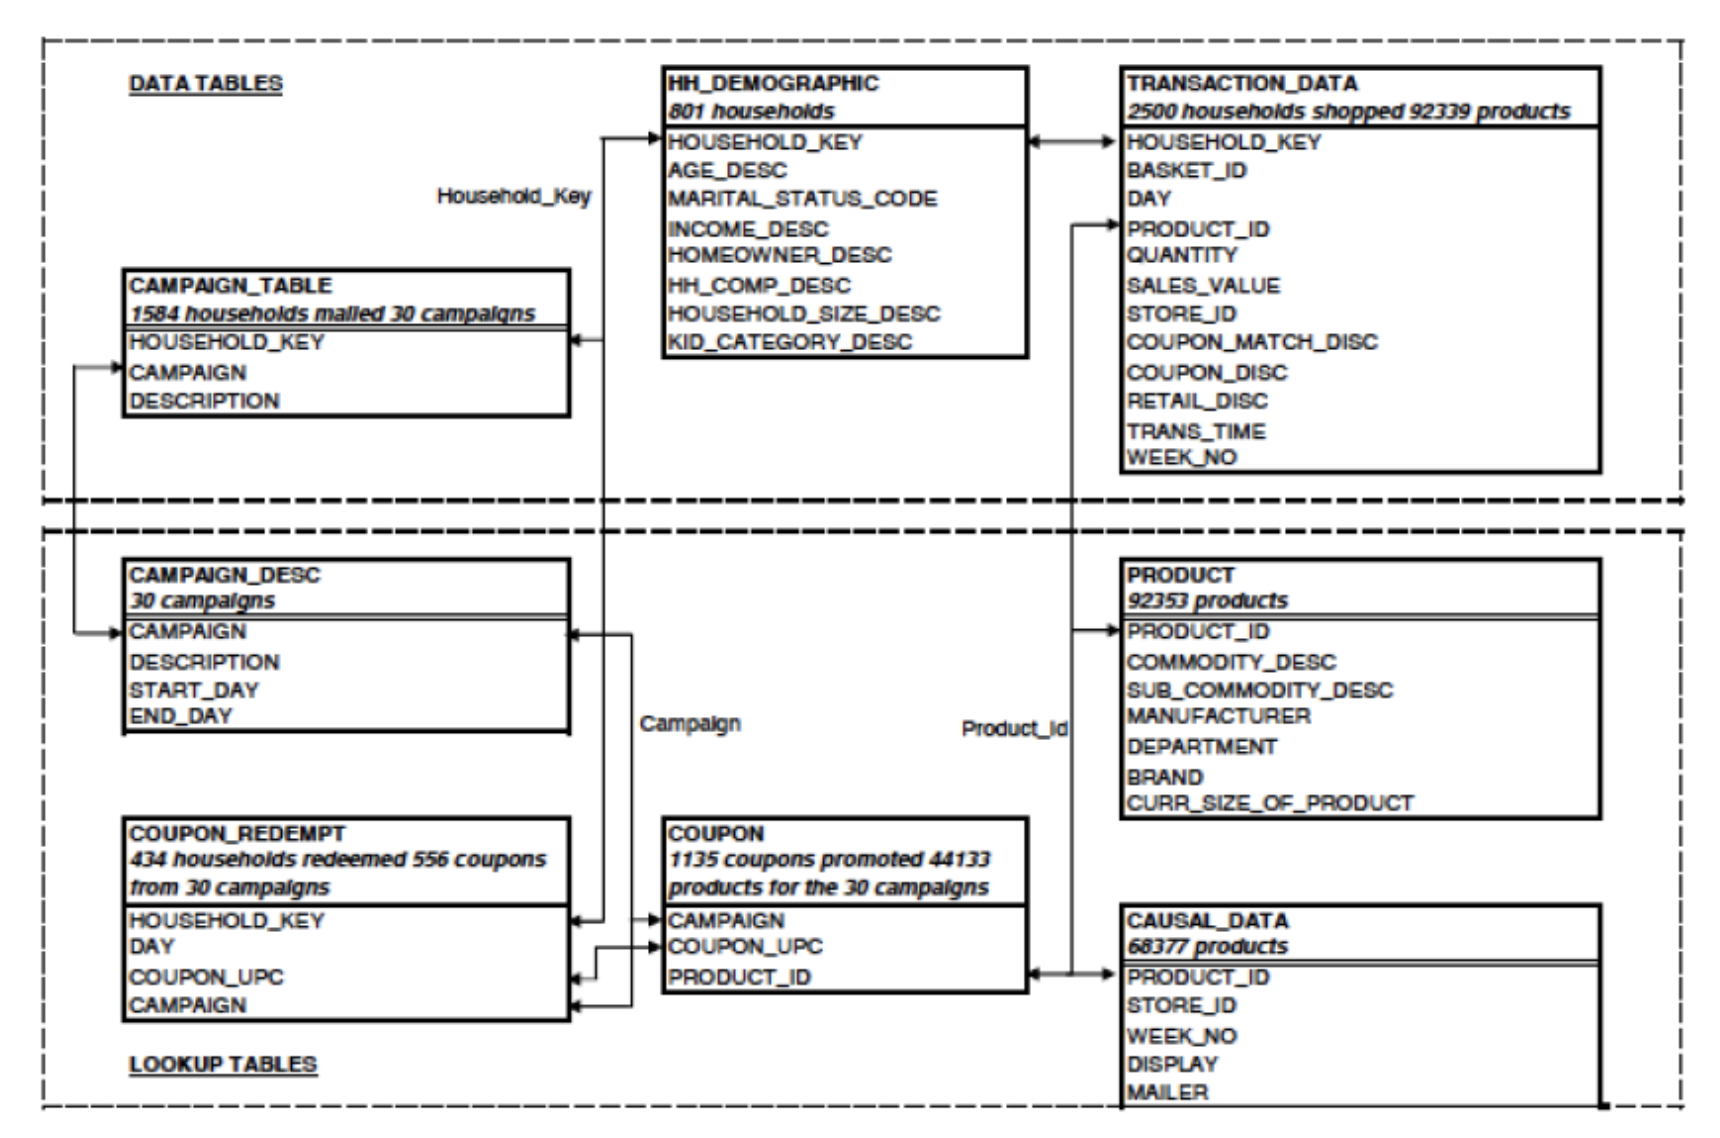

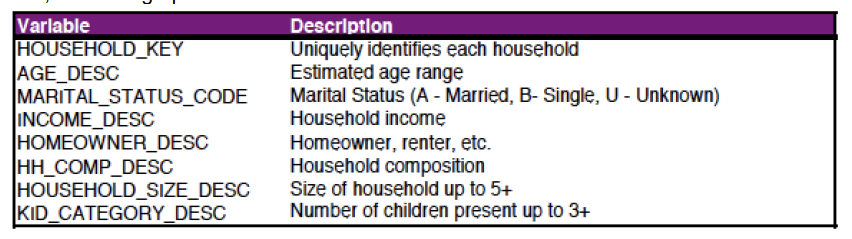

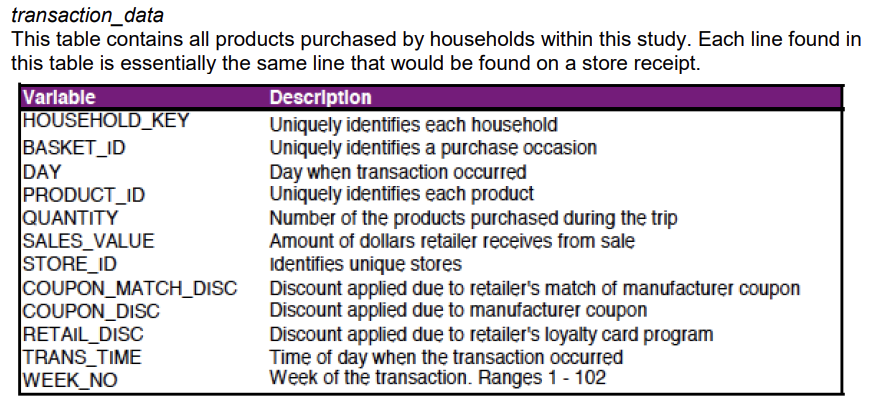

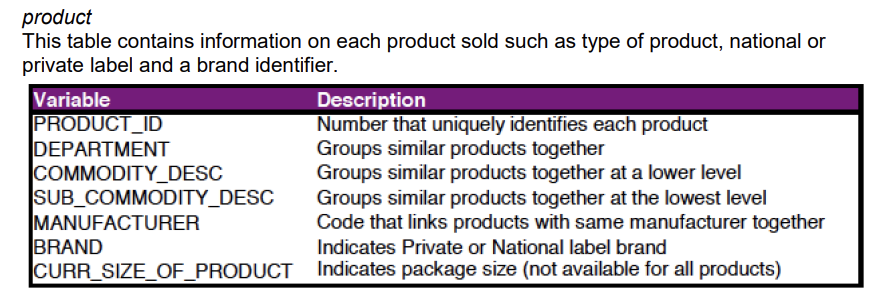

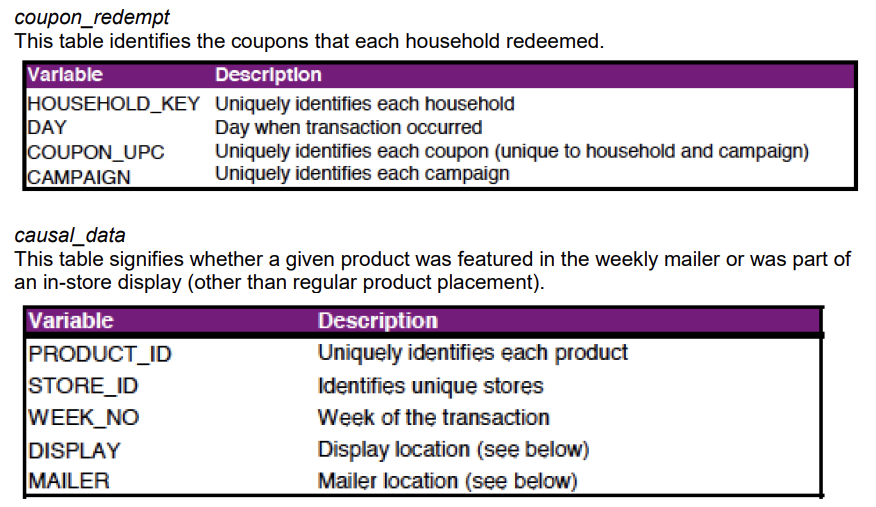

In [1]:
import numpy as np
import pandas as pd

In [2]:
# campaign_desc = pd.read_csv('campaign_desc.csv')
# campaign_table = pd.read_csv('campaign_table.csv')
# coupon = pd.read_csv('coupon.csv')
# coupon_redempt = pd.read_csv('coupon_redempt.csv')
causal_data = pd.read_csv('causal_data.csv')
hh_demographic = pd.read_csv('hh_demographic.csv')
product = pd.read_csv('product.csv')
transaction_data = pd.read_csv('transaction_data.csv')

Realizei uma análise simplificada usando apenas:
* transaction_data
* hh_demographic
* product
* causal_data

A ideia foi mostrar uma das várias possibilidades com essa base de dados. Podemos incluir mais variáveis e informações em futuras investigações

In [3]:
# Simples tratamento de dados faltantes e conversão de tipo para merge (join)

causal_data = causal_data.fillna(0)
hh_demographic = hh_demographic.fillna(0)
product = product.fillna(0)
transaction_data = transaction_data.fillna(0)

causal_data['WEEK_NO'] = causal_data['WEEK_NO'].astype(int)

In [4]:
df = pd.merge(transaction_data, hh_demographic, on='household_key', how='left')
df = pd.merge(df, product, on='PRODUCT_ID', how='left')
df = pd.merge(df, causal_data, on=['STORE_ID','PRODUCT_ID','WEEK_NO'], how='left')

In [5]:
df.head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,...,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT,Unnamed: 0,Unnamed: 0.1,display,mailer
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,...,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),5 LB,NaN,NaN,NaN,NaN
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,...,2,PRODUCE,National,ONIONS,ONIONS SWEET (BULK&BAG),40 LB,NaN,NaN,NaN,NaN
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,...,69,PRODUCE,Private,VEGETABLES - ALL OTHERS,CELERY,,NaN,NaN,NaN,NaN
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,...,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB,NaN,NaN,NaN,NaN
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,...,69,PRODUCE,Private,ORGANICS FRUIT & VEGETABLES,ORGANIC CARROTS,1 LB,NaN,NaN,NaN,NaN


In [6]:
df.columns

Index(['household_key', 'BASKET_ID', 'DAY', 'PRODUCT_ID', 'QUANTITY',
       'SALES_VALUE', 'STORE_ID', 'RETAIL_DISC', 'TRANS_TIME', 'WEEK_NO',
       'COUPON_DISC', 'COUPON_MATCH_DISC', 'AGE_DESC', 'MARITAL_STATUS_CODE',
       'INCOME_DESC', 'HOMEOWNER_DESC', 'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC',
       'KID_CATEGORY_DESC', 'MANUFACTURER', 'DEPARTMENT', 'BRAND',
       'COMMODITY_DESC', 'SUB_COMMODITY_DESC', 'CURR_SIZE_OF_PRODUCT',
       'Unnamed: 0', 'Unnamed: 0.1', 'display', 'mailer'],
      dtype='object')

Usando uma regressão da biblioteca XGBoost

In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# define the target variable
target = 'QUANTITY'

# define the features to use in the model
features = [
            #'STORE_ID', 
            # 'WEEK_NO', 
            # 'PRODUCT_ID',
            'AGE_DESC', 
            # 'MARITAL_STATUS_CODE',
            'INCOME_DESC', 
            # 'HOMEOWNER_DESC', 
            # 'HH_COMP_DESC', 
            # 'HOUSEHOLD_SIZE_DESC',
            # 'KID_CATEGORY_DESC', 
            # 'MANUFACTURER', 
            'DEPARTMENT', 
            # 'BRAND',
            # 'COMMODITY_DESC', 
            # 'SUB_COMMODITY_DESC', 
            # 'CURR_SIZE_OF_PRODUCT', 
            'display', 
            # 'mailer'
            ]

# convert categorical variables to binary using one-hot encoding
df_binary_features = pd.get_dummies(df[features])

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_binary_features, df[target], test_size=0.2)

# create an XGBoost regression model
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

# fit the model on the training data
xgb_model.fit(X_train, y_train)

# predict the target variable on the test data
y_pred = xgb_model.predict(X_test)

# calculate the root mean squared error of the predictions
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: %f" % (rmse))

RMSE: 369.646713


In [29]:
!pip install shap --quiet

In [30]:
import shap

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


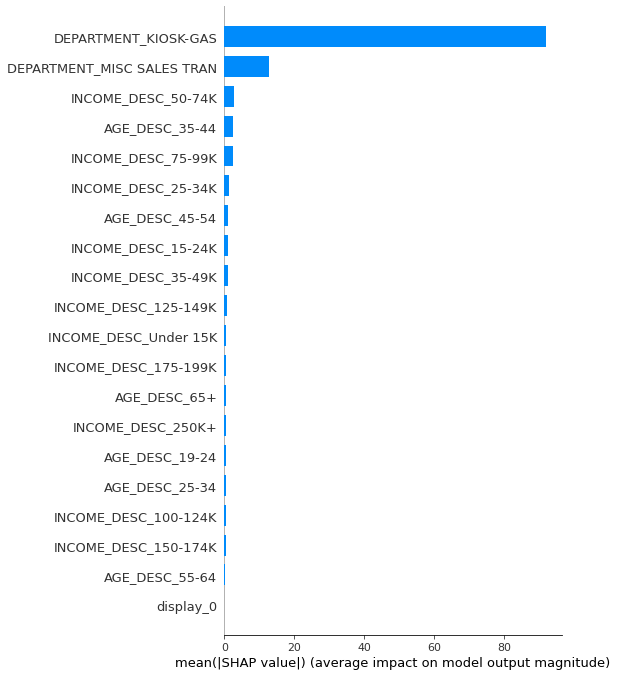

In [34]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

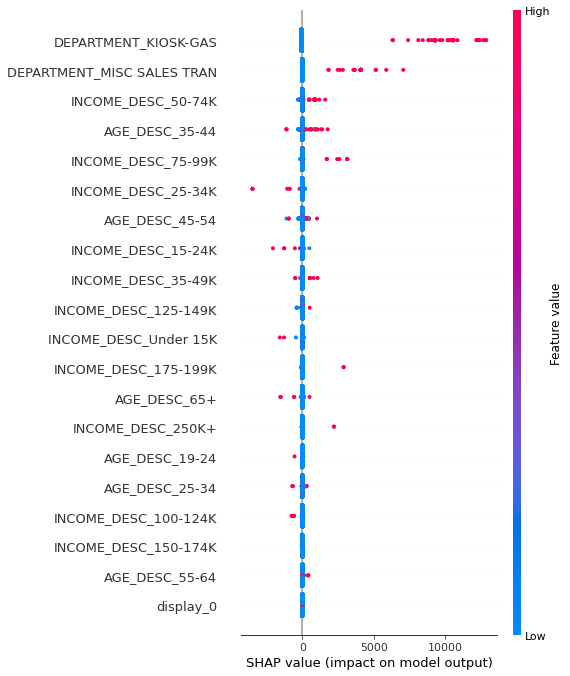

In [31]:
shap.summary_plot(shap_values, X_test)


Usando a biblioteca SHAP conseguimos observar as variáveis de maior influência do modelo. No caso, as características que dão maior propensão em quantidade de produtos comprados são:
1. 'Department-Kiosk-Gas' (gasolina), 
2. seguido por 'Department-Misc' (miscelânea?), 
3. renda anual entre 50mil e 74mil dólares e 
4. idade entre 35 e 44.
